In [1]:
!pip install pvlib pandas numpy

=== Iniciando simulação multi-Inversor/MPPT ===
Buscando NASA POWER: -22.841432,-51.957627 [Anos: 2015-2020]
❌ Erro NASA POWER: name 'get_nasa_power' is not defined
⚠️ Fonte NASA falhou. Tentando PVGIS.
Buscando PVGIS: -22.841432,-51.957627 [2015-2020]
✅ PVGIS OK: 52608 registros. GHI média: 215.8 W/m²

=== RESULTADO FINAL DO SISTEMA ===
Sistema total: 14.62 kWp | 2 Inversores
----------------------------------------
☀️ Geração DC Total (Teórica, sem perdas): 20,864 kWh/ano
✂️ Perda por Clipping: 174 kWh/ano (0.85 %)
⚡ Geração AC Total (Pré-Perdas Elétricas/Soiling): 20,273 kWh/ano

⚡ Geração AC Final (Pós-Perdas de 5.0%): 19,259 kWh/ano (7 anos)
💡 Consumo Anual: 17,133 kWh/ano
----------------------------------------
Yield específico (Sistema Total): 1,316.9 kWh/kWp
Fator de capacidade: 15.03 %
Performance Ratio (PR Total): 92.31 %

--- Performance e Geração por Inversor ---
╒════════════════╤═══════╤═════════════════════╤═══════════════════╤══════════╕
│ Inversor       │   kWp │   Ge

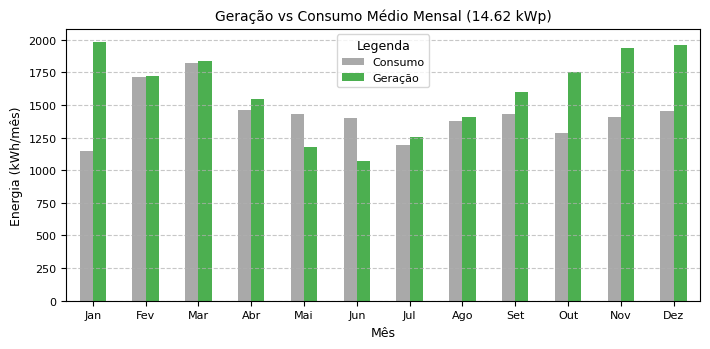

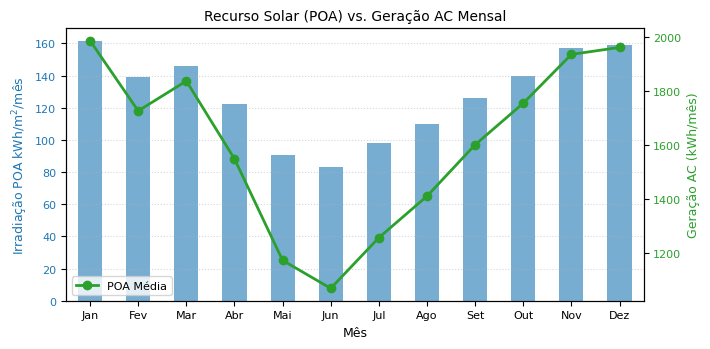

In [3]:
import math
import requests
import pandas as pd
import numpy as np
import pvlib
from pvlib import location, solarposition, irradiance, pvsystem, modelchain
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
# from pvlib.iotools import get_nasa_power
import matplotlib.pyplot as plt
from tabulate import tabulate

# ---------------------------
# CONFIGURAÇÃO INICIAL (INALTERADA)
# ---------------------------

# === ENTRADA DE DADOS DO USUÁRIO ===
# Informe o consumo médio mensal de JANEIRO a DEZEMBRO (em kWh)
monthly_consumption_kwh = [
    1146, 1718, 1822, 1460, 1434, 1400, # Jan a Jun
    1196, 1374, 1429, 1288, 1409, 1457  # Jul a Dez
]
# Define a fonte de dados preferencial: 'NASA' ou 'PVGIS'
# Se a fonte preferencial falhar, ele tenta a outra. Se as duas falharem, usa o sintético.
PREFERRED_DATA_SOURCE = 'NASA' # <=== Mude para 'PVGIS' se for a preferência
# =========================================

# NOVO: CONFIGURAÇÃO DE MÚLTIPLOS INVERSORES E SEUS MPPTs
inverter_configs = [
    {
        'name': 'INV-01 (3.0kW)',
        'paco_w': 5000, # Potência nominal AC do primeiro inversor (W)
        'efficiency_dc_ac': 0.98, # NOVO: Eficiência Nominal (98%)
        'mppts': [
            {'tilt': 18, 'azimuth': 330, 'modules_per_string': 4, 'strings': 1, 'id': 'MPPT-1A'},
            {'tilt': 18, 'azimuth': 60, 'modules_per_string': 4, 'strings': 1, 'id': 'MPPT-1B'},
        ]
    },
    {
        'name': 'INV-02 (7.5kW)',
        'paco_w': 7500, # Potência nominal AC do segundo inversor (W)
        'efficiency_dc_ac': 0.98, # NOVO: Eficiência Nominal (98%)
        'mppts': [
            {'tilt': 18, 'azimuth': 154, 'modules_per_string': 10, 'strings': 1, 'id': 'MPPT-2A'},
            {'tilt': 18, 'azimuth': 243, 'modules_per_string': 7, 'strings': 1, 'id': 'MPPT-2B'},
        ]
    }
]

# Coordenadas
lat, lon = -22.841432, -51.957627

potencia_modulo = 585 # Wp

# Perdas Totais
losses_parameters = {'soiling': 1.0, 'shading': 2.0, 'mismatch': 1.0, 'wiring': 0.5, 'Other': 0.5}

module_parameters = {
    'alpha_sc': 0.00041, 'beta_oc': -0.0025, 'gamma_r': -0.0029, 'cells_in_series': 144,
    'STC': potencia_modulo, 'V_oc_ref': 51.16, 'I_sc_ref': 14.55, 'V_mp_ref': 42.52,
    'I_mp_ref': 13.76, 'a_ref': 1.8, 'I_L_ref': 14.86, 'I_o_ref': 2.5e-12,
    'R_s': 0.25, 'R_sh_ref': 450.0,
}

# Opções: 'open_rack_glass_glass' (solo/aberto) ou 'close_mount_glass_glass' (telhado/restrito)
mount_type = 'close_mount_glass_glass'

# ---------------------------
# Funções utilitárias (FUNÇÃO NASA CORRIGIDA)
# ---------------------------

def buscar_dados_nasa(lat, lon, startyear=2015, endyear=2020, timeout=60):
    """
    Busca dados climáticos horários da API NASA POWER usando get_nasa_power.
    """
    try:
        print(f"Buscando NASA POWER: {lat},{lon} [Anos: {startyear}-{endyear}]")

        # A API retorna dados horários por padrão
        df_utc, metadata = get_nasa_power(
            latitude=lat,
            longitude=lon,
            start=f'{startyear}-01-01',
            end=f'{endyear}-12-31',
            parameters=['ghi', 'dni', 'dhi', 'temp_air', 'wind_speed'],
            community='re',
            map_variables=True
        )
    except Exception as e:
        print("❌ Erro NASA POWER:", e)
        return None

    if df_utc.empty:
        print("❌ NASA POWER retornou dados vazios.")
        return None

    df = df_utc.copy()

    # 1. Tratar NaNs e garantir float
    for col in ['ghi', 'dni', 'dhi', 'temp_air', 'wind_speed']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0.0)
        else:
            print(f"⚠️ Aviso: Coluna '{col}' não encontrada nos dados da NASA.")

    # 2. Definir fuso horário (NASA já retorna com tz-aware (UTC), então usamos apenas tz_convert)
    try:
        df.index = df.index.tz_convert('America/Sao_Paulo') # <--- CORREÇÃO APLICADA AQUI
    except TypeError as e:
        # Se por acaso a conversão falhar (dados não-aware), forçamos o localize e tentamos converter
        if "Already tz-aware" not in str(e):
             print("⚠️ Tentando forçar o fuso horário (timezone localization fallback).")
             df.index = df.index.tz_localize('UTC').tz_convert('America/Sao_Paulo')
        else:
             print(f"❌ Erro de fuso horário irrecuperável: {e}")
             return None

    # 3. Filtra apenas o ano necessário para a simulação
    df = df[(df.index.year >= startyear) & (df.index.year <= endyear)]
    df = df[~df.index.duplicated(keep='first')]

    print(f"✅ NASA POWER OK: {len(df)} registros. GHI média: {df['ghi'].mean():.1f} W/m²")
    return df

def buscar_dados_pvgis(lat, lon, startyear=2015, endyear=2020, timeout=60):
    url = f"https://re.jrc.ec.europa.eu/api/v5_2/seriescalc?lat={lat}&lon={lon}&startyear={startyear}&endyear={endyear}&outputformat=json&usehorizon=1&selectrad=1&angle=0&aspect=0"
    try:
        print(f"Buscando PVGIS: {lat},{lon} [{startyear}-{endyear}]")
        r = requests.get(url, timeout=timeout)
        r.raise_for_status()
        data = r.json()
    except Exception as e:
        print("❌ Erro PVGIS:", e)
        return None
    recs = []
    hourly = data.get('outputs', {}).get('hourly', [])
    for rec in hourly:
        try:
            dt = pd.to_datetime(rec['time'], format='%Y%m%d:%H%M', utc=True)
            recs.append({
                'datetime': dt,
                'ghi': float(rec.get('G(i)', 0.0)),
                'dni': float(rec.get('Gb(n)', 0.0)),
                'dhi': float(rec.get('Gd(i)', 0.0)),
                'temp_air': float(rec.get('T2m', 25.0)),
                'wind_speed': float(rec.get('WS10m', 2.0))
            })
        except:
            continue
    df = pd.DataFrame(recs).set_index('datetime')
    if df.empty:
        return None
    df.index = df.index.tz_convert('America/Sao_Paulo')
    print(f"✅ PVGIS OK: {len(df)} registros. GHI média: {df['ghi'].mean():.1f} W/m²")
    return df

def gerar_dados_sinteticos(lat, lon, start='2019-01-01', end='2019-12-31', tz='America/Sao_Paulo'):
    print("Gerando dados sintéticos (clear-sky) com perfil climático aprimorado...")
    times = pd.date_range(start=start, end=end, freq='1h', tz=tz)
    site = location.Location(lat, lon, tz=tz)
    cs = site.get_clearsky(times)
    df = cs.rename(columns={'ghi':'ghi','dni':'dni','dhi':'dhi'})

    FATOR_PERDA_NUVENS = 0.65

    df['ghi'] *= FATOR_PERDA_NUVENS
    df['dni'] *= FATOR_PERDA_NUVENS
    df['dhi'] *= FATOR_PERDA_NUVENS

    T_max = 30.0
    T_min = 20.0
    T_avg = (T_max + T_min) / 2
    T_amp = (T_max - T_min) / 2

    hour = df.index.hour
    df['temp_air'] = T_avg + T_amp * np.sin(2 * np.pi * (hour - 10) / 24.0)

    base_wind = 2.0
    df['wind_speed'] = base_wind + 0.5 * np.random.rand(len(df))

    return df

# ---------------------------
# Função principal multi-Inversor/MPPT (INALTERADA)
# ---------------------------

def calcular_sistema_solar_multi_mppt(
    lat, lon, inverter_configs, module_parameters, losses_parameters,
    monthly_consumption_kwh,
    mount_type,
    modelo_transposicao='perez', startyear=2015, endyear=2020,
    preferred_source='NASA', fallback_to_synthetic=True
):
    print("=== Iniciando simulação multi-Inversor/MPPT ===")

    meses_str = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']
    if len(monthly_consumption_kwh) != 12:
        print(f"❌ Erro: A lista de consumo deve ter 12 valores. Encontrado: {len(monthly_consumption_kwh)}")
        return None

    temp_model_key = mount_type
    temperature_model_params = TEMPERATURE_MODEL_PARAMETERS['sapm'].get(temp_model_key)
    if temperature_model_params is None:
        print(f"❌ Modelo de temperatura '{temp_model_key}' não encontrado. Abortando.")
        return None

    # -----------------------------------------------
    # ⭐️ LÓGICA DE BUSCA DE DADOS COM FALLBACK
    # -----------------------------------------------
    df = None

    # 1. Tenta a fonte preferencial
    if preferred_source == 'NASA':
        df = buscar_dados_nasa(lat, lon, startyear=startyear, endyear=endyear)
        if df is None:
            # 2. Tenta a alternativa (PVGIS)
            print("⚠️ Fonte NASA falhou. Tentando PVGIS.")
            df = buscar_dados_pvgis(lat, lon, startyear=startyear, endyear=endyear)
    elif preferred_source == 'PVGIS':
        df = buscar_dados_pvgis(lat, lon, startyear=startyear, endyear=endyear)
        if df is None:
            # 2. Tenta a alternativa (NASA)
            print("⚠️ Fonte PVGIS falhou. Tentando NASA POWER.")
            df = buscar_dados_nasa(lat, lon, startyear=startyear, endyear=endyear)

    # 3. Tenta dados sintéticos se fallback estiver ativado e ambas as APIs falharem
    if df is None and fallback_to_synthetic:
        print("⚠️ Ambas as fontes API falharam. Gerando dados sintéticos (fallback).")
        df = gerar_dados_sinteticos(lat, lon, start=f"{startyear}-01-01", end=f"{endyear}-12-31", tz='America/Sao_Paulo')

    if df is None or df.empty:
        print("❌ Não foi possível obter dados meteorológicos. Abortando.")
        return None
    # -----------------------------------------------

    solar_pos = solarposition.get_solarposition(df.index, lat, lon)
    if df['dni'].sum() == 0:
        decomp = irradiance.louche(ghi=df['ghi'], solar_zenith=solar_pos['zenith'], datetime_or_doy=df.index)
        df['dni'] = decomp['dni']
        df['dhi'] = decomp['dhi']

    # ---------------------------
    # Loop principal (por Inversor)
    # ---------------------------

    # Resultados consolidados
    ac_all = pd.Series(0.0, index=df.index)
    # DC Puro (sem Clipping e sem Perda de Eficiência DC/AC) - Denominador do PR
    dc_all_pre_clipping = pd.Series(0.0, index=df.index)

    results_inverter = {}
    poa_global_mppt_results = {}
    total_kwp_by_mppt_id = {}

    for inv_cfg in inverter_configs:
        inv_name = inv_cfg['name']
        paco_inv = inv_cfg['paco_w']
        mppts_list = inv_cfg['mppts']
        efficiency_factor = inv_cfg.get('efficiency_dc_ac', 1.0) # Fator de eficiência DC/AC

        # Inicializa a série DC Total PURO do Inversor (soma de todos os MPPTs)
        dc_inv_total_pure = pd.Series(0.0, index=df.index)
        kwp_inv = 0.0

        # Loop interno (por MPPT)
        for i, mppt in enumerate(mppts_list):
            mppt_id = mppt.get('id', f'{inv_name}_MPPT_{i+1}')

            current_mppt_kwp = (mppt['modules_per_string'] * mppt['strings'] * potencia_modulo) / 1000.0
            total_kwp_by_mppt_id[mppt_id] = current_mppt_kwp
            kwp_inv += current_mppt_kwp

            aoi = irradiance.aoi(mppt['tilt'], mppt['azimuth'], solar_pos['apparent_zenith'], solar_pos['azimuth'])
            dni_extra = irradiance.get_extra_radiation(df.index)

            poa_irrad = irradiance.get_total_irradiance(
                mppt['tilt'], mppt['azimuth'], solar_pos['apparent_zenith'], solar_pos['azimuth'],
                df['dni'], df['ghi'], df['dhi'],
                dni_extra=dni_extra,
                model=modelo_transposicao
            )

            poa_global_mppt_results[mppt_id] = poa_irrad['poa_global']

            weather_mppt = pd.DataFrame({
                'ghi': df['ghi'], 'dni': df['dni'], 'dhi': df['dhi'],
                'temp_air': df['temp_air'], 'wind_speed': df['wind_speed'],
                'poa_global': poa_irrad['poa_global'],
                'poa_direct': poa_irrad['poa_direct'], 'poa_diffuse': poa_irrad['poa_diffuse']
            }, index=df.index)

            pdc_stc_array = current_mppt_kwp * 1000.0

            # Usamos o truque para obter a potência DC pura (p_mp) sem a eficiência e clipping do PVwatts
            system = pvsystem.PVSystem(
                surface_tilt=mppt['tilt'], surface_azimuth=mppt['azimuth'],
                module_parameters={**module_parameters, 'module_type':'glass_glass'},
                modules_per_string=mppt['modules_per_string'],
                strings_per_inverter=mppt['strings'],
                inverter_parameters={'Paco': pdc_stc_array, 'Pdco': pdc_stc_array, 'pdc0': pdc_stc_array},
                temperature_model_parameters=temperature_model_params,
                losses_parameters={}
            )
            site = location.Location(lat, lon, tz='America/Sao_Paulo')
            mc = modelchain.ModelChain(system, site, aoi_model='physical', ac_model='pvwatts', transposition_model=modelo_transposicao)

            try:
                mc.run_model(weather_mppt)
            except Exception as e:
                print(f"❌ Erro ao rodar MPPT {mppt_id}:", e)
                continue

            dc_pre_clipping_mppt = mc.results.dc['p_mp'].fillna(0) # Potência DC pura do MPPT (sem clipping e sem perdas de inv)

            dc_inv_total_pure += dc_pre_clipping_mppt

        # ----------------------------------------------------
        # 5. CÁLCULO DO CLIPPING E ENERGIA AC NO NÍVEL DO INVERSOR
        # ----------------------------------------------------

        # ⭐️ NOVO: APLICA A PERDA DE EFICIÊNCIA DC -> AC NA POTÊNCIA DC (Perda por conversão)
        # Esta é a potência DC reduzida pela eficiência, ANTES do clipping
        dc_pre_clipping_with_eff = dc_inv_total_pure * efficiency_factor

        # Aplica o clipping na potência DC (já com a perda de eficiência)
        # O resultado é a Potência AC bruta do inversor (pré-perdas elétricas/soiling)
        ac_inv_output = np.minimum(dc_pre_clipping_with_eff, paco_inv)

        # Armazena os resultados deste inversor
        results_inverter[inv_name] = {
            'dc_pure': dc_inv_total_pure, # DC sem NENHUMA perda de inversor (PR Denominador)
            'ac_pre_losses': ac_inv_output, # AC após eficiência e clipping (PR Numerador pré-perdas CA)
            'paco_w': paco_inv,
            'kwp': kwp_inv
        }

        # Soma aos totais gerais
        ac_all += ac_inv_output
        dc_all_pre_clipping += dc_inv_total_pure # Soma o DC puro de todo o sistema

    # ---------------------------
    # CÁLCULOS FINAIS DO SISTEMA
    # ---------------------------

    # Aplica as perdas elétricas/soiling restantes (os 5.0% no exemplo)
    perdas_totais_pct = sum(losses_parameters.values())
    perdas_fator = (1.0 - perdas_totais_pct / 100.0)
    ac_after_losses = ac_all * perdas_fator

    potencia_total_kWp = sum(r['kwp'] for r in results_inverter.values())
    n_anos = df.index.year.nunique()

    # Geração total (após perdas finais)
    annual_energy_kwh = ac_after_losses.sum() / 1000.0 / n_anos

    # Geração AC Total Bruta (após clipping e eficiência, mas antes das perdas elétricas/soiling)
    annual_energy_total_kwh_pre_losses = ac_all.sum() / 1000.0 / n_anos

    # Geração DC Total (Teórica, sem clipping e sem perda de eficiência)
    annual_energy_dc_kwh = dc_all_pre_clipping.sum() / 1000.0 / n_anos

    # Perda por Clipping (DC que foi convertido para AC, mas limitado pelo Paco)
    # DC PURO - DC com Eficiência e Clipping
    dc_with_eff = dc_all_pre_clipping * efficiency_factor
    dc_with_eff_energy = dc_with_eff.sum() / 1000.0 / n_anos

    perda_clipping_kwh = dc_with_eff_energy - annual_energy_total_kwh_pre_losses
    perda_clipping_pct = (perda_clipping_kwh / dc_with_eff_energy) * 100.0 if dc_with_eff_energy > 0 else 0.0

    # CÁLCULO DA GERAÇÃO MÉDIA MENSAL (AC FINAL)
    monthly_energy_kwh = ac_after_losses.groupby(ac_after_losses.index.month).sum() / 1000.0 / n_anos
    monthly_energy_kwh.index = meses_str

    # ----------------------------------------------------
    # CÁLCULO POA E YIELD
    # ----------------------------------------------------
    df_poa_hourly = pd.DataFrame(poa_global_mppt_results)
    weights = pd.Series(total_kwp_by_mppt_id)
    poa_weighted_sum = (df_poa_hourly * weights).sum(axis=1)
    poa_weighted_average_hourly = poa_weighted_sum / weights.sum()

    monthly_poa_kwh_m2 = poa_weighted_average_hourly.groupby(poa_weighted_average_hourly.index.month).sum() / 1000.0 / n_anos
    monthly_poa_kwh_m2.index = meses_str

    yield_especifico = annual_energy_kwh / potencia_total_kWp
    fator_capacidade = (annual_energy_kwh / (potencia_total_kWp * 8760.0)) * 100.0

    # PR Total do Sistema
    PR_total = (ac_after_losses.sum() / dc_all_pre_clipping.sum()) if dc_all_pre_clipping.sum() > 0 else np.nan

    # ------------------------------------------------------------------
    # CÁLCULO DE RESULTADOS POR INVERSOR (PR Individual)
    # ------------------------------------------------------------------
    inverter_summary = []

    # Recalcula o fator de perdas apenas para o restante (perdas elétricas, soiling, etc.)
    remaining_perdas_fator = perdas_fator

    for inv_name, data in results_inverter.items():
        # Geração AC Final do Inversor (aplicando as perdas restantes - elétricas/soiling)
        ac_final_inv_kwh = (data['ac_pre_losses'] * remaining_perdas_fator).sum() / 1000.0 / n_anos

        # Geração DC (Pré-Clipping, DC PURO) do Inversor
        dc_inv_kwh = data['dc_pure'].sum() / 1000.0 / n_anos

        # PR por Inversor (AC Final / DC Puro)
        pr_inv = (ac_final_inv_kwh / dc_inv_kwh) if dc_inv_kwh > 0 else np.nan

        yield_inv = (ac_final_inv_kwh / data['kwp']) if data['kwp'] > 0 else 0

        inverter_summary.append({
            'Inversor': inv_name,
            'kWp': data['kwp'],
            'Geração AC (kWh/ano)': ac_final_inv_kwh,
            'Yield (kWh/kWp)': yield_inv,
            'PR (%)': pr_inv * 100.0
        })

    # ************************************************
    # CÁLCULOS DE COMPARAÇÃO COM CONSUMO
    # ************************************************
    consumption_series = pd.Series(monthly_consumption_kwh, index=meses_str)

    comparison_df = pd.DataFrame({
        'Consumo (kWh)': consumption_series,
        'Geração (kWh)': monthly_energy_kwh.round(0).astype(int),
        'Diferença (kWh)': (monthly_energy_kwh - consumption_series).round(0).astype(int)
    })

    annual_consumption_kwh = consumption_series.sum()

    # ---------------------------
    # Resultados (impressão)
    # ---------------------------
    print("\n" + "="*50)
    print("=== RESULTADO FINAL DO SISTEMA ===")
    print("="*50)
    print(f"Sistema total: {potencia_total_kWp:.2f} kWp | {len(inverter_configs)} Inversores")
    print("-" * 40)
    print(f"☀️ Geração DC Total (Teórica, sem perdas): {annual_energy_dc_kwh:,.0f} kWh/ano")
    print(f"✂️ Perda por Clipping: {perda_clipping_kwh:,.0f} kWh/ano ({perda_clipping_pct:.2f} %)")
    print(f"⚡ Geração AC Total (Pré-Perdas Elétricas/Soiling): {annual_energy_total_kwh_pre_losses:,.0f} kWh/ano")
    print(f"\n⚡ Geração AC Final (Pós-Perdas de {perdas_totais_pct:.1f}%): {annual_energy_kwh:,.0f} kWh/ano ({n_anos} anos)")
    print(f"💡 Consumo Anual: {annual_consumption_kwh:,.0f} kWh/ano")
    print("-" * 40)
    print(f"Yield específico (Sistema Total): {yield_especifico:,.1f} kWh/kWp")
    print(f"Fator de capacidade: {fator_capacidade:.2f} %")
    print(f"Performance Ratio (PR Total): {PR_total*100:.2f} %\n")
    print("="*50)

    # ------------------------------------------------------------------
    # Tabela por Inversor (PR Individual)
    # ------------------------------------------------------------------
    print("--- Performance e Geração por Inversor ---")

    tabela_inv_list = []
    for data in inverter_summary:
        tabela_inv_list.append([
            data['Inversor'],
            data['kWp'],
            int(round(data['Geração AC (kWh/ano)'])),
            data['Yield (kWh/kWp)'],
            data['PR (%)']
        ])

    headers = ["Inversor", "kWp", "Geração (kWh/ano)", "Yield (kWh/kWp)", "PR (%)"]

    print(tabulate(tabela_inv_list, headers=headers, tablefmt="fancy_grid",
                    numalign="right", stralign="left", floatfmt=(".0f", ".2f", ",.0f", ",.1f", ".2f")))

    # --- Tabela de Comparação ---
    print("\n--- Comparativo Mensal (Geração vs Consumo) ---")

    print(tabulate(comparison_df, headers="keys", tablefmt="grid",
                    numalign="right", stralign="right", floatfmt=",.0f"))

    print("-" * 40)

    # ------------------------------------------------------------------
    # 📊 GRÁFICO 1: Geração Total vs Consumo (Barras)
    # ------------------------------------------------------------------
    print("...Gerando Gráfico 1: Geração vs Consumo (Barras)")

    plot_df = pd.DataFrame({
        'Consumo': consumption_series,
        'Geração': monthly_energy_kwh
    })

    plt.figure(figsize=(7.2, 3.6))

    plot_df.plot(kind='bar', color=['#A9A9A9', '#4CAF50'], rot=0, ax=plt.gca())

    plt.title(f'Geração vs Consumo Médio Mensal ({potencia_total_kWp:.2f} kWp)', fontsize=10)
    plt.xlabel('Mês', fontsize=9)
    plt.ylabel('Energia (kWh/mês)', fontsize=9)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Legenda', fontsize=8, title_fontsize=9)
    plt.tight_layout()

    # ------------------------------------------------------------------
    # 📈 GRÁFICO 2: Irradiação POA Corrigida (Barras)
    # ------------------------------------------------------------------
    print("...Gerando Gráfico 2: Irradiação POA Corrigida (Barras)")

    fig, ax1 = plt.subplots(figsize=(7.2, 3.6))

    color = 'tab:blue'
    ax1.set_xlabel('Mês', fontsize=9)
    ax1.set_ylabel(r'Irradiação POA $\text{kWh/m}^2/\text{mês}$', color=color, fontsize=9)
    monthly_poa_kwh_m2.plot(kind='bar', ax=ax1, color=color, alpha=0.6, rot=0)
    ax1.tick_params(axis='y', labelcolor=color, labelsize=8)
    ax1.tick_params(axis='x', labelsize=8)
    ax1.grid(axis='y', linestyle=':', alpha=0.5)

    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('Geração AC (kWh/mês)', color=color, fontsize=9)
    monthly_energy_kwh.plot(kind='line', ax=ax2, color=color, linewidth=2, marker='o', label='Geração AC Final')
    ax2.tick_params(axis='y', labelcolor=color, labelsize=8)

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, ['POA Média', 'Geração AC Final'], loc='best', fontsize=8)

    plt.title('Recurso Solar (POA) vs. Geração AC Mensal', fontsize=10)
    plt.tight_layout()
    plt.show()

    # ---------------------------

    return {
        'ac_after_losses': ac_after_losses,
        'dc_all_pre_clipping': dc_all_pre_clipping,
        'annual_energy_kwh_final': annual_energy_kwh,
        'monthly_energy_kwh_final': monthly_energy_kwh.to_dict(),
        'comparison_monthly_df': comparison_df,
        'perda_clipping_kwh': perda_clipping_kwh,
        'PR_total': PR_total,
        'inverter_summary': inverter_summary
    }

# ---------------------------
# Execução
# ---------------------------

if __name__ == "__main__":
    res = calcular_sistema_solar_multi_mppt(
        lat, lon, inverter_configs, module_parameters, losses_parameters,
        monthly_consumption_kwh,
        mount_type=mount_type,
        modelo_transposicao='perez', startyear=2015, endyear=2020,
        preferred_source=PREFERRED_DATA_SOURCE,
        fallback_to_synthetic=True
    )

In [4]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [5]:
!pip install numpy-financial

--- ANÁLISE DE VIABILIDADE FINANCEIRA: CENÁRIOS [1, 2, 3] ---

### PARÂMETROS GERAIS DO PROJETO
Cenários Selecionados: (1, 2, 3)
Capacidade do BESS necessária: 481,03 kWh
Número de baterias: 118
Vida Útil da Simulação BESS/FV: 22.99 anos


### CENÁRIO 1: BESS (CARREGAMENTO REDE)

- CAPE. Total: R$ 950.000,00
- Economia/Lucro Anual no 1º ano: R$ 130.949,12

--- Métricas Financeiras ---
  - Payback Simples: 6.17 anos
  - Payback Descontado: 8.15 anos
  - VPL: R$ 1.771.810,27
  - TIR: 20.31%
  - Índice de Lucratividade (IL): 1.87 X
  - LCOE: R$ 1,46/kWh
  - ROI: 701.75%


### CENÁRIO 2: BESS + FV

- CAPE. Total: R$ 1.184.600,00
- Economia/Lucro Anual no 1º ano: R$ 222.908,95
- Sobra de geração FV (abate fora de ponta): 98.966,22 kWh

--- Métricas Financeiras ---
  - Payback Simples: 4.74 anos
  - Payback Descontado: 5.93 anos
  - VPL: R$ 3.484.784,77
  - TIR: 25.95%
  - Índice de Lucratividade (IL): 2.94 X
  - LCOE: R$ 0,53/kWh
  - ROI: 998.89%


### CENÁRIO 3: GERADOR A DIESEL

- CAPE. T

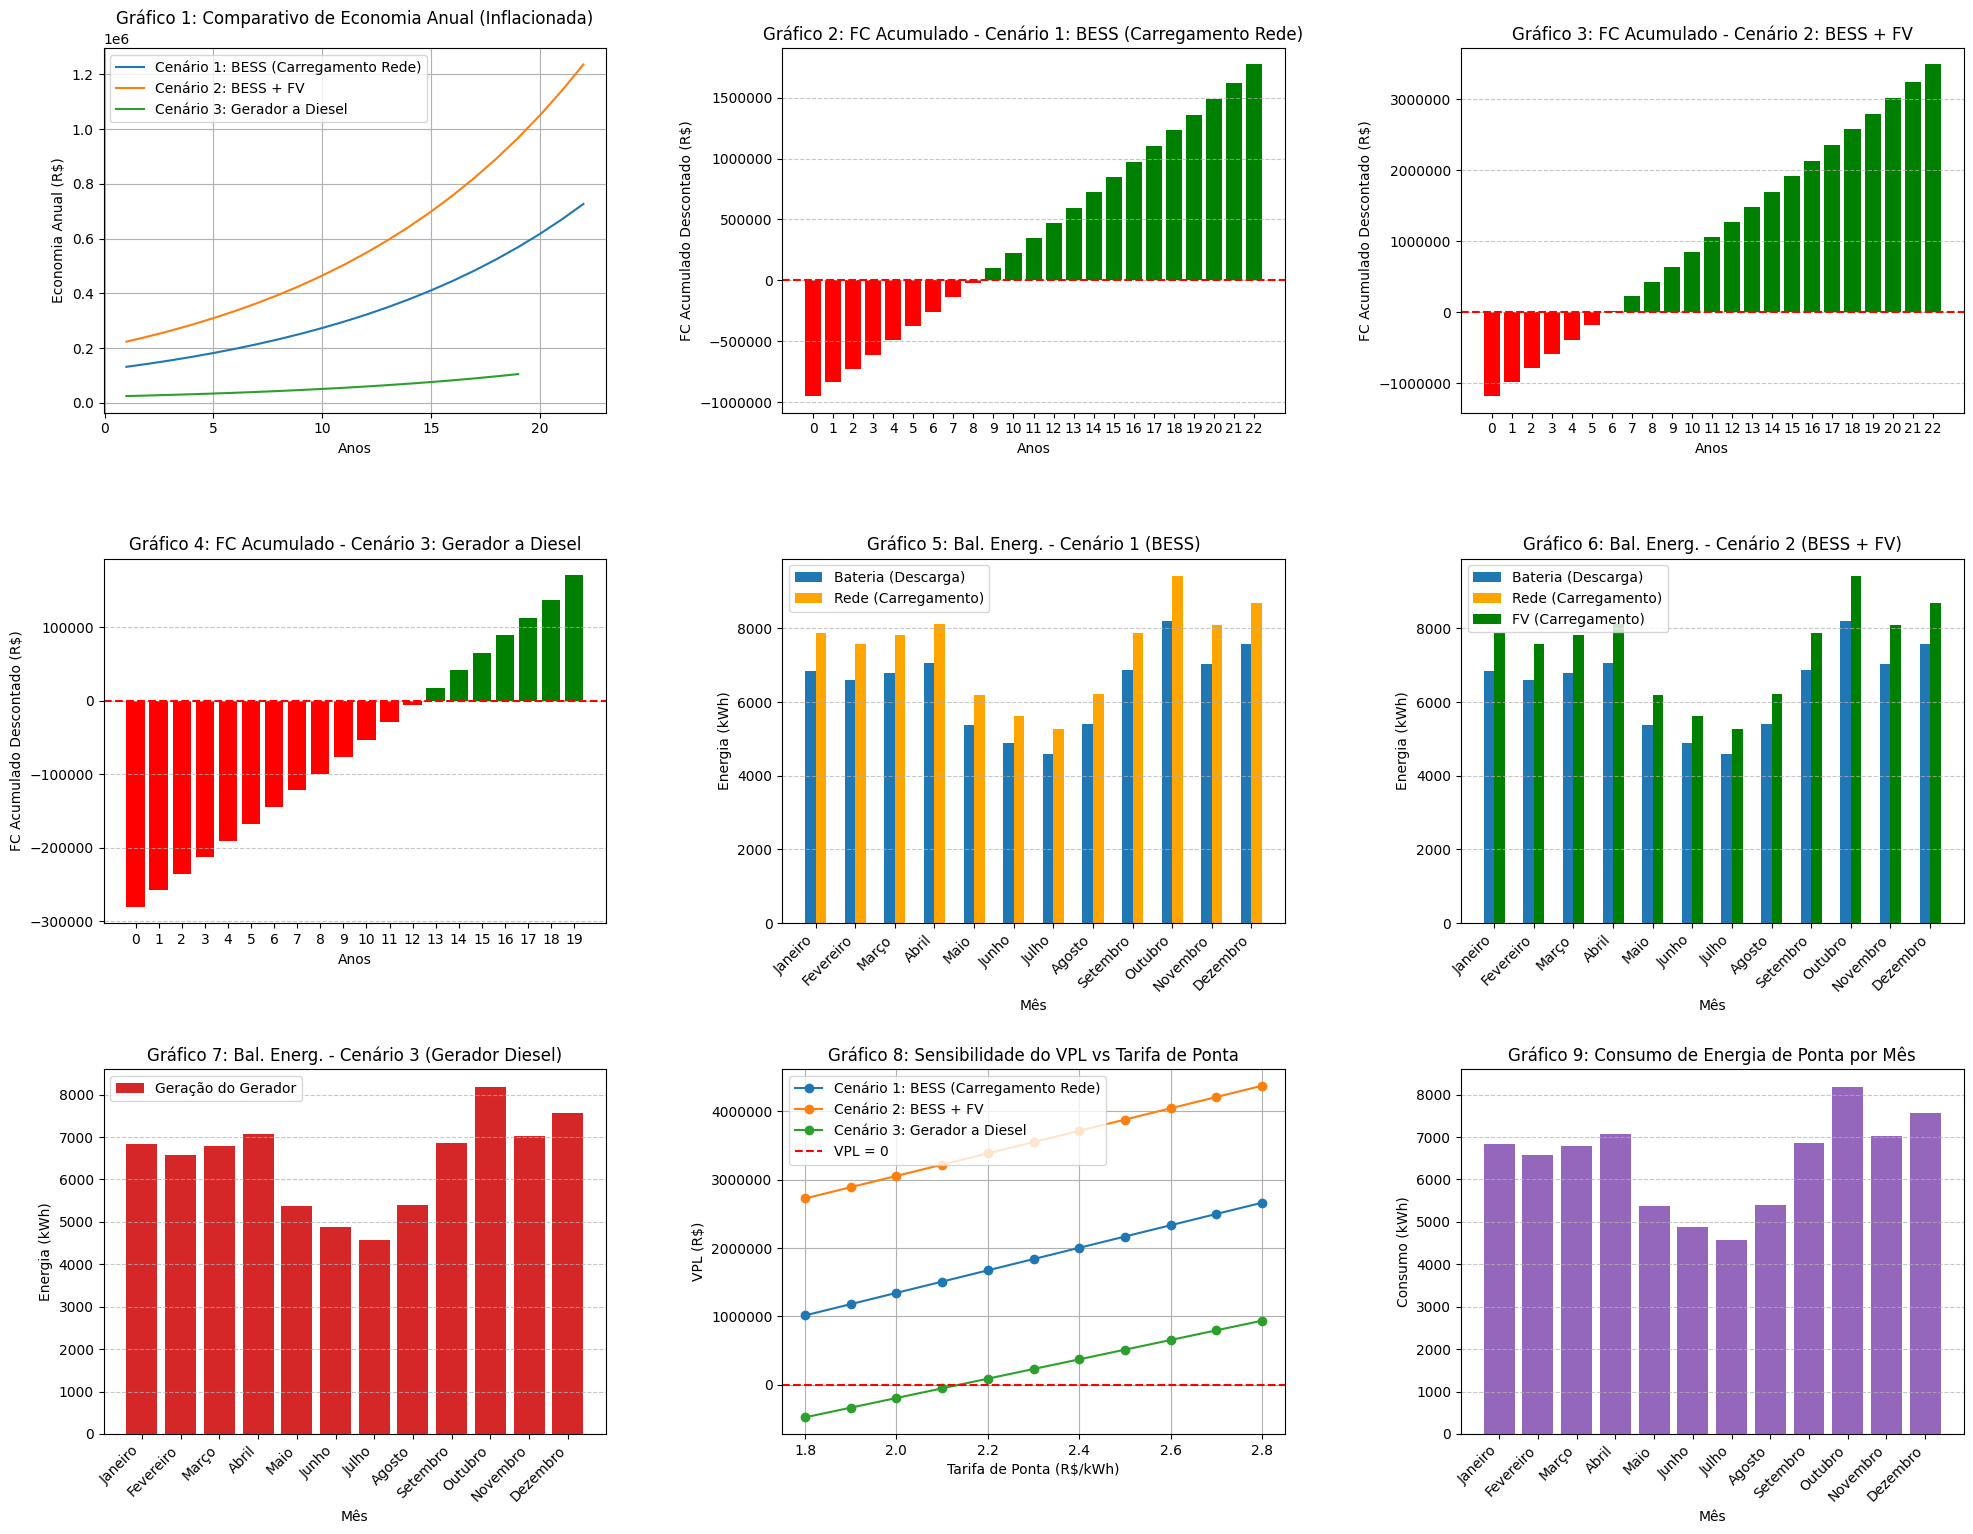

In [6]:
# Módulo de Dimensionamento e Viabilidade BESS/FV/Gerador
# VERSÃO FLEXÍVEL COM GRÁFICO DE SENSIBILIDADE DINÂMICO
# Autor: Gemini
# Data: 25/09/2025

# --- INSTALAÇÃO E IMPORTAÇÃO DE BIBLIOTERIAS ---
try:
    import numpy_financial as npf
except ImportError:
    print("A biblioteca numpy_financial não foi encontrada. Instalando...")
    !pip install numpy-financial
    import numpy_financial as npf

import math
import numpy as np
import matplotlib.pyplot as plt

# --- PARÂMETROS DE ENTRADA E SELEÇÃO DE CENÁRIOS ---
# 1. SELEÇÃO DE CENÁRIOS: Defina quais cenários simular.
# Opções: (1,), (2,), (3,), (1, 2), (1, 3), (2, 3), ou (1, 2, 3) para todos.
CENARIOS_PARA_SIMULAR = (1, 2, 3) # <<< EX: Todos os 3 Cenários

# 2. Dados de Consumo Mensal (em kWh)
consumo_ponta_mensal = {
    "Janeiro": 6843, "Fevereiro": 6583, "Março": 6794, "Abril": 7068,
    "Maio": 5373, "Junho": 4889, "Julho": 4583, "Agosto": 5408,
    "Setembro": 6855, "Outubro": 8192, "Novembro": 7024, "Dezembro": 7563
}
consumo_fora_ponta_mensal = {
    "Janeiro": 67899, "Fevereiro": 66125, "Março": 63902, "Abril": 53747,
    "Maio": 41235, "Junho": 35482, "Julho": 39550, "Agosto": 47887,
    "Setembro": 57350, "Outubro": 61091, "Novembro": 54413, "Dezembro": 53338
}

# 3. Informações Financeiras e de Demanda
tarifa_ponta = 2.26 # R$/kWh (Tarifa base para cálculo inicial)
tarifa_fora_ponta = 0.49 # R$/kWh

# 4. Parâmetros de Viabilidade Financeira
taxa_desconto = 0.08 # 8%
inflacao_energia = 0.085 # 6.5%
taxa_om_anual = 0.01 # 0% (O&M para BESS/FV)

# 5. Parâmetros Técnicos da Bateria e Projeto
potencia_modulo_bateria = 5.12 # kW
profundidade_descarga = 0.90 # 90%
fator_correcao_perdas = 0.87 # Perdas do sistema (inversor, etc.)
numero_ciclos = 6000
capacidade_residual_eol = 0.80 # 80% de capacidade no fim da vida útil
dias_uteis_no_ano_real = 261
dias_uteis_medio = dias_uteis_no_ano_real / 12
vida_util_projeto = numero_ciclos / dias_uteis_no_ano_real
degradacao_anual = 1 - (capacidade_residual_eol)**(1/vida_util_projeto)

# 6. Geração Fotovoltaica
geracao_fv_mensal = {
    "Janeiro": 16858.57, "Fevereiro": 15794.34, "Março": 16577.98, "Abril": 14886.24,
    "Maio": 13866.34, "Junho": 13395.98, "Julho": 13811.02, "Agosto": 16190.61,
    "Setembro": 15083.82, "Outubro": 16858.57, "Novembro": 16605.65, "Dezembro": 17744.00
}
potencia_fv_kWp = 102 # kWp

# 7. Parâmetros de Custo (CAPEX)
capex_bess = 950000.00
capex_fv = 234600.00
valor_residual_bess = 0.10
valor_residual_fv = 0.10

# 8. PARÂMETROS PARA O GERADOR A DIESEL
capex_gerador = 280000.00 # R$
consumo_diesel_l_por_kwh = 0.30 # L/kWh
custo_diesel_litro = 5.89 # R$/L
vida_util_gerador_horas = 15000 # horas
taxa_om_gerador_anual = 0.05 # 5% do CAPEX
valor_residual_gerador = 0.15 # 15% do CAPEX
horas_operacao_gerador_anual = dias_uteis_no_ano_real * 3
vida_util_gerador_anos = vida_util_gerador_horas / horas_operacao_gerador_anual

# 9. PARÂMETRO DE DIMENSIONAMENTO
metodo_dimensionamento = "maior_consumo"


# --- FUNÇÕES DE CÁLCULO FINANCEIRO (MANTIDAS) ---
def calcular_metricas_financeiras(capex, fluxo_caixa_anual, valor_residual_total, anos_vida_util):
    """Calcula Payback Simples, VPL, TIR, Payback Descontado e IL."""

    payback_simples = 0
    acumulado_simples = -capex
    for i, fc in enumerate(fluxo_caixa_anual):
        acumulado_simples += fc
        if acumulado_simples >= 0:
            payback_simples = i + 1 - (acumulado_simples / fc)
            break

    fluxo_caixa_com_residual = fluxo_caixa_anual[:]
    if len(fluxo_caixa_com_residual) > 0:
        fluxo_caixa_com_residual[-1] += valor_residual_total

    vpl = npf.npv(taxa_desconto, [-capex] + fluxo_caixa_com_residual)

    try:
        tir = npf.irr([-capex] + fluxo_caixa_com_residual)
    except:
        tir = np.nan

    payback_descontado = 0
    acumulado_desc = -capex
    fluxo_caixa_descontado = [fc / (1 + taxa_desconto)**(i + 1) for i, fc in enumerate(fluxo_caixa_com_residual)]

    for i, fc_desc in enumerate(fluxo_caixa_descontado):
        acumulado_desc += fc_desc
        if acumulado_desc >= 0:
            payback_descontado = i + 1 - (acumulado_desc / fc_desc)
            break

    indice_lucratividade = vpl / capex if capex > 0 else 0
    roi_bruto = sum(fluxo_caixa_com_residual)
    roi = (roi_bruto - capex) / capex if capex > 0 else 0

    fluxo_caixa_acumulado_descontado = np.cumsum([-capex] + fluxo_caixa_descontado)

    return {
        "Payback Simples": payback_simples,
        "Payback Descontado": payback_descontado,
        "VPL": vpl,
        "TIR": tir,
        "Índice de Lucratividade": indice_lucratividade,
        "ROI": roi,
        "Fluxo de Caixa Acumulado Descontado": fluxo_caixa_acumulado_descontado
    }

def calcular_lcoe(capex, vida_util, taxa_desconto, energia_gerada_anual):
    """Calcula o Custo Nivelado de Energia (LCOE)."""

    fluxo_caixa_com_caex = [-capex]
    for ano in range(int(vida_util)):
        custo_om = (capex * taxa_om_anual) * (1 + inflacao_energia)**ano
        fluxo_caixa_com_caex.append(-custo_om)

    npv_custos = npf.npv(taxa_desconto, fluxo_caixa_com_caex)

    energia_anual_desc = [energia_gerada_anual / (1 + taxa_desconto)**(ano + 1) for ano in range(int(vida_util))]
    npv_energia = sum(energia_anual_desc)

    if npv_energia == 0:
        return float('inf')

    lcoe = npv_custos / npv_energia
    return abs(lcoe)

def calcular_vpl_sensibilidade(cenario, tarifa_teste, capex, vida_util):
    """Calcula o VPL para uma dada tarifa de ponta (usado no gráfico de sensibilidade)."""
    consumo_anual_ponta_kwh = sum(consumo_ponta_mensal.values())

    if cenario == 1: # BESS - Carregamento com Rede
        economia_anual = 0
        for mes, consumo_ponta in consumo_ponta_mensal.items():
            energia_para_carregar = consumo_ponta / fator_correcao_perdas
            custo_carregamento = energia_para_carregar * tarifa_fora_ponta
            economia_bruta = consumo_ponta * tarifa_teste
            economia_anual += (economia_bruta - custo_carregamento)

        fluxo_caixa_anual = [economia_anual * (1 + inflacao_energia)**ano - capex*taxa_om_anual for ano in range(int(vida_util))]
        valor_residual_total = capex_bess * valor_residual_bess

    elif cenario == 2: # BESS + FV
        economia_anual = 0
        for mes, consumo_ponta in consumo_ponta_mensal.items():
            energia_para_carregar = consumo_ponta / fator_correcao_perdas
            energia_fv_usada_bess = min(geracao_fv_mensal[mes], energia_para_carregar)
            sobra_fv = geracao_fv_mensal[mes] - energia_fv_usada_bess
            economia_bruta = consumo_ponta * tarifa_teste
            economia_anual += economia_bruta + (sobra_fv * tarifa_fora_ponta)

        fluxo_caixa_anual = [economia_anual * (1 + inflacao_energia)**ano - capex*taxa_om_anual for ano in range(int(vida_util))]
        valor_residual_total = (capex_bess * valor_residual_bess) + (capex_fv * valor_residual_fv)

    elif cenario == 3: # Gerador a Diesel
        consumo_diesel_anual_teste = consumo_anual_ponta_kwh * consumo_diesel_l_por_kwh
        custo_diesel_anual_teste = consumo_diesel_anual_teste * custo_diesel_litro
        custo_om_gerador_anual_teste = capex_gerador * taxa_om_gerador_anual
        custo_total_anual_teste = custo_diesel_anual_teste + custo_om_gerador_anual_teste

        fluxo_caixa_anual = []
        for a in range(int(vida_util)):
            receita_anual_inflacionada = consumo_anual_ponta_kwh * (tarifa_teste * (1 + inflacao_energia)**a)
            custo_total_inflacionado = custo_total_anual_teste * (1 + inflacao_energia)**a
            fluxo_caixa_anual.append(receita_anual_inflacionada - custo_total_inflacionado)

        valor_residual_total = capex_gerador * valor_residual_gerador

    fluxo_caixa_com_residual = fluxo_caixa_anual[:]
    if len(fluxo_caixa_com_residual) > 0:
        fluxo_caixa_com_residual[-1] += valor_residual_total

    return npf.npv(taxa_desconto, [-capex] + fluxo_caixa_com_residual)


# --- PRÉ-CÁLCULOS E DIMENSIONAMENTO BASE (MANTIDOS) ---
consumo_anual_ponta_kwh = sum(consumo_ponta_mensal.values())
dias_uteis_medio = dias_uteis_no_ano_real / 12
if metodo_dimensionamento == "maior_consumo":
    energia_mensal_base = max(consumo_ponta_mensal.values())
else:
    energia_mensal_base = np.mean(list(consumo_ponta_mensal.values()))

consumo_diario_ponta_util = energia_mensal_base / dias_uteis_medio
capacidade_util_necessaria = consumo_diario_ponta_util / fator_correcao_perdas
capacidade_total_bateria_necessaria = capacidade_util_necessaria / profundidade_descarga
numero_baterias_final = math.ceil((capacidade_total_bateria_necessaria / potencia_modulo_bateria) / (1 - degradacao_anual)**vida_util_projeto)
geracao_anual_fv = sum(geracao_fv_mensal.values())
energia_bess_anual = consumo_anual_ponta_kwh / fator_correcao_perdas

meses_com_defasagem = []
for mes, geracao in geracao_fv_mensal.items():
    energia_bess_mensal_necessaria = consumo_ponta_mensal[mes] / fator_correcao_perdas
    if geracao < energia_bess_mensal_necessaria:
        defasagem = energia_bess_mensal_necessaria - geracao
        meses_com_defasagem.append(f"{mes}: {defasagem:,.2f} kWh".replace(",", "X").replace(".", ",").replace("X", "."))


# --- DICIONÁRIO PARA ARMAZENAR RESULTADOS ---
resultados_simulados = {}

# --- CENÁRIO 1: CARREGAMENTO COM A REDE (BESS) ---
if 1 in CENARIOS_PARA_SIMULAR:
    economia_liquida_anual_1 = 0
    for mes, consumo_ponta in consumo_ponta_mensal.items():
        energia_descarregada_mensal = consumo_ponta
        energia_para_carregar = energia_descarregada_mensal / fator_correcao_perdas
        custo_carregamento_mensal = energia_para_carregar * tarifa_fora_ponta
        economia_bruta_mensal = energia_descarregada_mensal * tarifa_ponta
        economia_liquida_anual_1 += (economia_bruta_mensal - custo_carregamento_mensal)

    fluxo_caixa_anual_1 = []
    for ano in range(int(vida_util_projeto)):
        economia_ano = economia_liquida_anual_1 * (1 + inflacao_energia)**ano
        custo_om_ano = capex_bess * taxa_om_anual
        fluxo_caixa_ano = economia_ano - custo_om_ano
        fluxo_caixa_anual_1.append(fluxo_caixa_ano)

    resultados_1 = calcular_metricas_financeiras(capex_bess, fluxo_caixa_anual_1, capex_bess * valor_residual_bess, vida_util_projeto)
    lcoe_1 = calcular_lcoe(capex_bess, vida_util_projeto, taxa_desconto, sum(consumo_ponta_mensal.values()))

    resultados_simulados[1] = {
        "nome": "Cenário 1: BESS (Carregamento Rede)",
        "capex": capex_bess,
        "economia_anual": economia_liquida_anual_1,
        "metricas": resultados_1,
        "lcoe": lcoe_1,
        "vida_util": vida_util_projeto
    }


# --- CENÁRIO 2: CARREGAMENTO COM GERAÇÃO FV (BESS + FV) ---
if 2 in CENARIOS_PARA_SIMULAR:
    economia_liquida_anual_2 = 0
    sobra_fv_anual_kwh = 0
    sobra_fv_anual_reais = 0
    for mes, consumo_ponta in consumo_ponta_mensal.items():
        energia_descarregada_mensal = consumo_ponta
        energia_para_carregar_bess = energia_descarregada_mensal / fator_correcao_perdas
        geracao_fv_mes = geracao_fv_mensal[mes]
        energia_fv_usada_bess = min(geracao_fv_mes, energia_para_carregar_bess)
        sobra_fv_mes = geracao_fv_mensal[mes] - energia_fv_usada_bess
        sobra_fv_anual_kwh += sobra_fv_mes
        sobra_fv_anual_reais += (sobra_fv_mes * tarifa_fora_ponta)
        economia_bruta_mensal = energia_descarregada_mensal * tarifa_ponta
        economia_liquida_anual_2 += economia_bruta_mensal + (sobra_fv_mes * tarifa_fora_ponta)

    capex_total = capex_bess + capex_fv
    fluxo_caixa_anual_2 = []
    for ano in range(int(vida_util_projeto)):
        economia_ano = economia_liquida_anual_2 * (1 + inflacao_energia)**ano
        custo_om_ano = capex_total * taxa_om_anual
        fluxo_caixa_ano = economia_ano - custo_om_ano
        fluxo_caixa_anual_2.append(fluxo_caixa_ano)

    valor_residual_total = (capex_bess * valor_residual_bess) + (capex_fv * valor_residual_fv)
    resultados_2 = calcular_metricas_financeiras(capex_total, fluxo_caixa_anual_2, valor_residual_total, vida_util_projeto)
    lcoe_2 = calcular_lcoe(capex_total, vida_util_projeto, taxa_desconto, sum(consumo_ponta_mensal.values()) + geracao_anual_fv)

    resultados_simulados[2] = {
        "nome": "Cenário 2: BESS + FV",
        "capex": capex_total,
        "economia_anual": economia_liquida_anual_2,
        "metricas": resultados_2,
        "lcoe": lcoe_2,
        "sobra_fv_kwh": sobra_fv_anual_kwh,
        "sobra_fv_reais": sobra_fv_anual_reais,
        "vida_util": vida_util_projeto
    }


# --- CENÁRIO 3: GERADOR A DIESEL ---
if 3 in CENARIOS_PARA_SIMULAR:
    consumo_diesel_anual_l = consumo_anual_ponta_kwh * consumo_diesel_l_por_kwh
    custo_diesel_anual = consumo_diesel_anual_l * custo_diesel_litro
    custo_om_gerador_anual = capex_gerador * taxa_om_gerador_anual
    custo_operacional_total_anual = custo_diesel_anual + custo_om_gerador_anual

    economia_anual_gerador = (consumo_anual_ponta_kwh * tarifa_ponta) - custo_operacional_total_anual

    fluxo_caixa_anual_gerador = []
    for ano in range(int(vida_util_gerador_anos)):
        receita_anual_inflacionada = consumo_anual_ponta_kwh * (tarifa_ponta * (1 + inflacao_energia)**ano)
        custo_total_inflacionado = custo_operacional_total_anual * (1 + inflacao_energia)**ano
        fluxo_caixa_ano = receita_anual_inflacionada - custo_total_inflacionado
        fluxo_caixa_anual_gerador.append(fluxo_caixa_ano)

    resultados_3 = calcular_metricas_financeiras(capex_gerador, fluxo_caixa_anual_gerador, capex_gerador * valor_residual_gerador, vida_util_gerador_anos)
    lcoe_3 = calcular_lcoe(capex_gerador, vida_util_gerador_anos, taxa_desconto, consumo_anual_ponta_kwh)

    resultados_simulados[3] = {
        "nome": "Cenário 3: Gerador a Diesel",
        "capex": capex_gerador,
        "economia_anual": economia_anual_gerador,
        "metricas": resultados_3,
        "lcoe": lcoe_3,
        "consumo_diesel_l": consumo_diesel_anual_l,
        "custo_operacional": custo_operacional_total_anual,
        "vida_util": vida_util_gerador_anos
    }

# --- EXIBIÇÃO DE RESULTADOS E ANÁLISE DE CENÁRIOS (MANTIDA COM LOOP) ---

print("="*80)
print(f"--- ANÁLISE DE VIABILIDADE FINANCEIRA: CENÁRIOS {list(CENARIOS_PARA_SIMULAR)} ---")
print("="*80)

# Parâmetros Gerais (MANTIDOS)
print("\n### PARÂMETROS GERAIS DO PROJETO")
print(f"Cenários Selecionados: {CENARIOS_PARA_SIMULAR}")
print(f"Capacidade do BESS necessária: {capacidade_total_bateria_necessaria:,.2f} kWh".replace(",", "X").replace(".", ",").replace("X", "."))
print(f"Número de baterias: {numero_baterias_final}")
print(f"Vida Útil da Simulação BESS/FV: {vida_util_projeto:.2f} anos")

# Resumo por Cenário (MANTIDO COM LOOP)
for num, dados in resultados_simulados.items():
    print("\n" + "="*80)
    print(f"\n### {dados['nome'].upper()}")
    print(f"\n- CAPEX Total: R$ {dados['capex']:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))
    print(f"- Economia/Lucro Anual no 1º ano: R$ {dados['economia_anual']:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))

    if num == 2:
        print(f"- Sobra de geração FV (abate fora de ponta): {dados['sobra_fv_kwh']:,.2f} kWh".replace(",", "X").replace(".", ",").replace("X", "."))
    elif num == 3:
        print(f"- Custo Operacional Anual no 1º ano: R$ {dados['custo_operacional']:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))

    print("\n--- Métricas Financeiras ---")
    print(f"  - Payback Simples: {dados['metricas']['Payback Simples']:.2f} anos")
    print(f"  - Payback Descontado: {dados['metricas']['Payback Descontado']:.2f} anos")
    print(f"  - VPL: R$ {dados['metricas']['VPL']:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))
    print(f"  - TIR: {dados['metricas']['TIR']:.2%}")
    print(f"  - Índice de Lucratividade (IL): {dados['metricas']['Índice de Lucratividade']:.2f} X")
    print(f"  - LCOE: R$ {dados['lcoe']:,.2f}/kWh".replace(",", "X").replace(".", ",").replace("X", "."))
    print(f"  - ROI: {dados['metricas']['ROI']:.2%}")

print("="*80)
print("\n")


# --- GRÁFICOS DINÂMICOS (ADICIONANDO SENSIBILIDADE) ---

if resultados_simulados:

    num_cenarios_simulados = len(resultados_simulados)

    # Total de gráficos: 1 (Economia Comparativa) + N (FC Acumulado) + N (Balanço Energético) + 1 (Sensibilidade) + 1 (Consumo)
    # Para 3 cenários, teremos 1 + 3 + 3 + 1 + 1 = 9 gráficos. Vamos usar um layout 3x3.
    # Para 2 cenários, teremos 1 + 2 + 2 + 1 + 1 = 7 gráficos. Layout 3x3 (últimas 2 vazias).
    # Para 1 cenário, teremos 1 + 1 + 1 + 1 + 1 = 5 gráficos. Layout 2x3.

    num_plots_necessarios = 3 + (2 * num_cenarios_simulados)

    # Define o layout: sempre 3 colunas, número de linhas é ajustado
    num_colunas = 3
    num_linhas = math.ceil(num_plots_necessarios / num_colunas)

    fig, ax = plt.subplots(num_linhas, num_colunas, figsize=(8 * num_colunas, 6 * num_linhas))
    plt.subplots_adjust(wspace=0.35, hspace=0.4)

    ax = ax.flatten() if num_linhas > 1 or num_colunas > 1 else np.array([ax]) # Aplanar para fácil indexação

    meses = list(consumo_ponta_mensal.keys())
    posicao_barras = np.arange(len(meses))
    largura_barra = 0.8 / num_cenarios_simulados

    # ----------------------------------------------------
    # GRÁFICO 1: Comparativo de Economia Anual (Posição 0)
    ax[0].set_title('Gráfico 1: Comparativo de Economia Anual (Inflacionada)')
    ax[0].set_xlabel('Anos')
    ax[0].set_ylabel('Economia Anual (R$)')

    for num, dados in resultados_simulados.items():
        vida_util = int(dados['vida_util'])
        anos = range(1, vida_util + 1)
        economia_anual_inflacionada = [dados['economia_anual'] * (1 + inflacao_energia)**ano for ano in range(vida_util)]
        ax[0].plot(anos, economia_anual_inflacionada, label=dados['nome'])

    ax[0].legend()
    ax[0].grid(True)

    # ----------------------------------------------------
    # GRÁFICOS DE 2 a N+1: Fluxo de Caixa Acumulado
    for i, (num, dados) in enumerate(resultados_simulados.items()):

        ax_fc = ax[i + 1]

        fc_acumulado = dados['metricas']['Fluxo de Caixa Acumulado Descontado']
        anos_fc = range(len(fc_acumulado))
        cores = ['green' if val >= 0 else 'red' for val in fc_acumulado]

        ax_fc.bar(anos_fc, fc_acumulado, color=cores)
        ax_fc.set_title(f'Gráfico {i+2}: FC Acumulado - {dados["nome"]}')
        ax_fc.set_xlabel('Anos')
        ax_fc.set_ylabel('FC Acumulado Descontado (R$)')
        ax_fc.axhline(y=0, color='r', linestyle='--')
        ax_fc.grid(True, axis='y', linestyle='--', alpha=0.7)
        ax_fc.set_xticks(anos_fc)
        ax_fc.ticklabel_format(style='plain', axis='y')

    # ----------------------------------------------------
    # GRÁFICOS DE N+2 a 2N+1: Balanço Energético Mensal

    idx_energetico_inicial = num_cenarios_simulados + 1

    mapa_grafico_energia = {
        1: {"title": "Bal. Energ. - Cenário 1 (BESS)", "data_fn": lambda: ({
            'Descarga (BESS)': list(consumo_ponta_mensal.values()),
            'Carregamento (Rede)': [c / fator_correcao_perdas for c in consumo_ponta_mensal.values()]
        }), "colors": ['tab:blue', 'orange', 'none']},

        2: {"title": "Bal. Energ. - Cenário 2 (BESS + FV)", "data_fn": lambda: ({
            'Descarga (BESS)': list(consumo_ponta_mensal.values()),
            'Carregamento (Rede)': [max(0, (consumo_ponta_mensal[m] / fator_correcao_perdas) - geracao_fv_mensal[m]) for m in meses],
            'Carregamento (FV)': [min(geracao_fv_mensal[m], consumo_ponta_mensal[m] / fator_correcao_perdas) for m in meses]
        }), "colors": ['tab:blue', 'orange', 'green']},

        3: {"title": "Bal. Energ. - Cenário 3 (Gerador Diesel)", "data_fn": lambda: ({
            'Geração (Diesel)': list(consumo_ponta_mensal.values())
        }), "colors": ['tab:red', 'none', 'none']}
    }

    for i, num in enumerate(CENARIOS_PARA_SIMULAR):

        ax_balanco = ax[idx_energetico_inicial + i]
        config = mapa_grafico_energia.get(num)

        if config:
            dados_balanco = config["data_fn"]()
            cores = config["colors"]

            ax_balanco.set_title(f'Gráfico {idx_energetico_inicial + i + 1}: {config["title"]}')
            ax_balanco.set_xlabel('Mês')
            ax_balanco.set_ylabel('Energia (kWh)')

            descarga = dados_balanco.get('Descarga (BESS)', dados_balanco.get('Geração (Diesel)', None))
            carregamento_rede = dados_balanco.get('Carregamento (Rede)', None)
            carregamento_fv = dados_balanco.get('Carregamento (FV)', None)

            if num in [1, 2]: # BESS
                ax_balanco.bar(posicao_barras - largura_barra/2, descarga, width=largura_barra, label='Bateria (Descarga)', color=cores[0])

                posicao_barras_carregamento = posicao_barras + largura_barra/2
                bottom = np.zeros(len(meses))

                if carregamento_rede is not None and cores[1] != 'none':
                    ax_balanco.bar(posicao_barras_carregamento, carregamento_rede, width=largura_barra, label='Rede (Carregamento)', color=cores[1])
                    bottom = carregamento_rede

                if carregamento_fv is not None and cores[2] != 'none':
                    ax_balanco.bar(posicao_barras_carregamento, carregamento_fv, width=largura_barra, bottom=bottom, label='FV (Carregamento)', color=cores[2])

            elif num == 3: # Gerador
                ax_balanco.bar(posicao_barras, descarga, width=0.8, label='Geração do Gerador', color=cores[0])

            ax_balanco.set_xticks(posicao_barras)
            ax_balanco.set_xticklabels(meses, rotation=45, ha='right')
            ax_balanco.legend()
            ax_balanco.grid(True, axis='y', linestyle='--', alpha=0.7)

    # ----------------------------------------------------
    # GRÁFICO 2N+2: Análise de Sensibilidade do VPL (Novo Gráfico Fixo)

    idx_sensibilidade = 2 * num_cenarios_simulados + 1
    ax_sensibilidade = ax[idx_sensibilidade]

    faixa_tarifa = np.arange(1.80, 2.81, 0.10)

    for num, dados in resultados_simulados.items():
        if num == 1:
            capex = capex_bess
            vida_util = vida_util_projeto
            vpls = [calcular_vpl_sensibilidade(1, t, capex, vida_util) for t in faixa_tarifa]
            ax_sensibilidade.plot(faixa_tarifa, vpls, label=dados['nome'], marker='o')
        elif num == 2:
            capex = capex_bess + capex_fv
            vida_util = vida_util_projeto
            vpls = [calcular_vpl_sensibilidade(2, t, capex, vida_util) for t in faixa_tarifa]
            ax_sensibilidade.plot(faixa_tarifa, vpls, label=dados['nome'], marker='o')
        elif num == 3:
            capex = capex_gerador
            vida_util = vida_util_gerador_anos
            vpls = [calcular_vpl_sensibilidade(3, t, capex, vida_util) for t in faixa_tarifa]
            ax_sensibilidade.plot(faixa_tarifa, vpls, label=dados['nome'], marker='o')


    ax_sensibilidade.set_title(f'Gráfico {idx_sensibilidade + 1}: Sensibilidade do VPL vs Tarifa de Ponta')
    ax_sensibilidade.set_xlabel('Tarifa de Ponta (R$/kWh)')
    ax_sensibilidade.set_ylabel('VPL (R$)')
    ax_sensibilidade.axhline(y=0, color='r', linestyle='--', label='VPL = 0')
    ax_sensibilidade.legend()
    ax_sensibilidade.grid(True)
    ax_sensibilidade.ticklabel_format(style='plain', axis='y')

    # ----------------------------------------------------
    # GRÁFICO FINAL: Consumo de Energia de Ponta por Mês (Fixo na última posição)

    ax_consumo_ponta = ax[num_plots_necessarios - 1] # A última posição do array de plots

    ax_consumo_ponta.bar(posicao_barras, consumo_ponta_mensal.values(), color='tab:purple')
    ax_consumo_ponta.set_title(f'Gráfico {num_plots_necessarios}: Consumo de Energia de Ponta por Mês')
    ax_consumo_ponta.set_xlabel('Mês')
    ax_consumo_ponta.set_ylabel('Consumo (kWh)')
    ax_consumo_ponta.set_xticks(posicao_barras)
    ax_consumo_ponta.set_xticklabels(meses, rotation=45, ha='right')
    ax_consumo_ponta.grid(True, axis='y', linestyle='--', alpha=0.7)

    # Limpar eixos não utilizados (se o layout for maior que o necessário)
    for i in range(num_plots_necessarios, len(ax)):
        fig.delaxes(ax[i])

    plt.show()

else:
    print("\nAVISO: Nenhum cenário foi selecionado para simulação. Por favor, ajuste o parâmetro CENARIOS_PARA_SIMULAR.")